# General Info

Part 2 of the project. To be submitted by **08/11/2024 23:59**

-> Total = **50** pts

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc, f1_score, confusion_matrix, silhouette_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from scipy.interpolate import griddata
from sklearn.tree import plot_tree

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# set display option to show all columns
pd.set_option('display.max_columns', None)

# Datasets

<p><img alt="Datasets" src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png" align="left" hspace="10px" vspace="0px"></p>

# Global Variables

In [2]:
data_dir = "data/"
train_data_path = data_dir + "application_train.csv.zip"

In [3]:
### 1- Load the dataset "dataset"
### This dataset should be the app_train from the question 6.a of part 1 (Refer to correction if need be). 
### You can include the previous notebook here, but we recommend instead you export it from previous notebook then load it here.

# we will use default data and then preprocess it the same way we did in the question 6.a (undersampleData() function)
dataset = pd.read_csv(train_data_path, compression="zip")

In [4]:
dataset

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## **A**. Processing the provided dataset  (review from past assignment, 7 pts)

**1.** Process the categorical features to be correctly handled. Use the most appropriate methods from sklearn (**2** pts)

**2.** Process the anomalies of the dataset (**1** pt)

**3.** Expand the 5 most important features (justify what 'important' means for you) using PolynomialFeatures (**2** pts). You may need to process missing values before.

**4.** Process the features using the best Scaler (**2** pts)

### **A.1** & **A.2**

For the preprocessing we call `cleanData()` function, which does the following:
1. Handles `NaN` values using `handleNans()` function.
2. Undersamples $0$ class (majority class).
3. Handles anomalies in the data using `handleAnomalies()` function.
4. Handles categorical features by applying handleCategorical() function.

For a detailed preprocessing strategy please refer to the functions descriptions.

In [5]:
def handleNans(df: pd.DataFrame, row_thres: float=0.05, col_thres: float=0.25, do_step_4=True) -> pd.DataFrame:
  """
  Handles missing data in the following ways:
    1. Drops the column if more than a given percentage (col_thres) of data is missing.
        If the number of missing values in a column is too much relative to the total number of rows (25%), we drop the column.
    2. Drops rows with missing values if the percentage of missing values in a column is below a threshold (row_thres).
        If the number of missing values in a column is low relative to the total number of rows (`5%`), we drop the rows containing these missing values
        (we assume that the missing values are anomalies or rare cases).
    3. Fill NaN values in categorical columns as class "missing". We consider a variable as categorical if:
        - its dtype is "object"
        - its dtype is "int64"
        - its dtype is "int32"
        - its dtype is "bool"
        After analysis: for app_train, this step does not actually do anything: there are no NaNs in categorical columns
    4. For the rest (numerical columns), fills NaNs with the median of the column, since median is less sensitive to skewed data.

  Parameters:
    - df (pd.DataFrame): The input DataFrame with missing data.
    - row_thres (float): The threshold percentage (default 5%) to drop rows with missing values.
    - col_thres (float): The threshold percentage (default 50%) to drop columns with too many missing values.
    - do_step_4 (bool): Whether to perform 4th step of preprocessing or not.

  Returns:
    - df_ (pd.DataFrame): The DataFrame after handling missing data.
  """
  df_ = df.copy()
  missing_percentage = df_.isnull().mean() # calculate the percentage of missing values for each column
  # step 1: drop columns where the missing percentage is greater than the column threshold
  df_ = df_.loc[:, missing_percentage <= col_thres]
  # step 2: drop rows for columns where missing percentage is less than the row threshold
  columns_to_drop_rows = missing_percentage[missing_percentage < row_thres].index
  df_ = df_.dropna(subset=columns_to_drop_rows)
  # step 3: fill NaNs in categorical columns with "missing"
  #     after analysis: for app_train, this step does not actually do anything: there are no NaNs in categorical columns
  categorical_columns = df_.select_dtypes(include=["object", "int64", "int32", "bool"]).columns
  df_[categorical_columns] = df_[categorical_columns].fillna("missing")
  # step 4: fill NaNs in numerical columns with the median of the column
  if do_step_4:
    numerical_columns = df_.select_dtypes(include=[np.number]).columns
    df_[numerical_columns] = df_[numerical_columns].fillna(df_[numerical_columns].median())
  return df_

def undersampleData(df: pd.DataFrame, ratio=2) -> pd.DataFrame:
    """
    Undersamples data, with 1 minority class.

    Parameters:
        - df (pd.DataFrame): Dataframe to be undersampled.
        - ratio (int): Imbalance ratio between the majority class and minority class.

    Returns:
        - df_undersampled_shuffled (pd.DataFrame): DataFrame with undersampled 0 class.
    """
    df_ = df.copy()
    class_0 = df_[df_["TARGET"] == 0]
    class_1 = df_[df_["TARGET"] == 1]
    # undersample the majority class
    class_0_undersampled = class_0.sample(n=len(class_1)*ratio, random_state=0)
    # combine the undersampled class_0 and class_1
    df_undersampled = pd.concat([class_0_undersampled, class_1])
    # shuffle the dataset
    df_undersampled_shuffled = df_undersampled.sample(frac=1, random_state=0).reset_index(drop=True)
    return df_undersampled_shuffled

def encodeBinary(df: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    """
    Encodes binary categorical columns (with only two unique values) using LabelEncoder.
    Transforms unique values into labels 0 or 1 (does not create a one-hot vector).

    Parameters:
        - df (pd.DataFrame): Dataframe containing columns to be binary encoded.
        - columns (list[str]): List of column names to be binary encoded.

    Returns:
        - (pd.DataFrame): DataFrame with specified columns binary encoded (0, 1).
    """
    label_encoder = LabelEncoder()
    for column in columns:
        df[column] = label_encoder.fit_transform(df[column]).astype(int)
    return df

def transformChildren(df: pd.DataFrame):
    """
    Transforms the classes in "CNT_CHILDREN" column into 4 classes.

    Parameters:
        - df (pd.DataFrame): Input dataframe containing the "CNT_CHILDREN" column.

    Returns:
        - df_ (pd.DataFrame): DataFrame with "CNT_CHILDREN" transformed into categorical bins.
    """
    df_ = df.copy()
    bins = [-1, 0, 1, 3, float("inf")]  # ranges: -1-0, 1-2, 3-4, 5+
    labels = ["0 children", "1 child", "2-3 children", "4+ children"]
    df_["CNT_CHILDREN"] = pd.cut(df_["CNT_CHILDREN"], bins=bins, labels=labels)
    return df_

def handleCategorical(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handles categorical variables in a DataFrame by:
        1. Transforming "CNT_CHILDREN" into categorical bins, 4 classes total.
        2. Identifying binary columns (for LabelEncoder) and columns for factorization.
        3. Encoding the binary columns and factorizing the rest.
        4. Rename column names if duplicates exist.

    Parameters:
        - df (pd.DataFrame): Input dataframe with categorical variables.

    Returns:
        - df_ (pd.DataFrame): DataFrame with binary and factorized columns.
    """
    df_ = df.copy()
    # 1. transform CNT_CHILDREN into categorical variable
    if "CNT_CHILDREN" in df_.columns:
        df_ = transformChildren(df=df_)
    # 2. get categorical columns
    cat_columns = df_.select_dtypes(include=["object", "int64", "int32", "category"]).columns
    cols_to_exclude = [
        "SK_ID_CURR", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_ID_PUBLISH", "HOUR_APPR_PROCESS_START"
    ]
    # filter out excluded columns
    cat_columns = cat_columns[~np.isin(cat_columns, cols_to_exclude)]
    # define columns to binarize and factorize
    to_binarize = [col for col in cat_columns if df_[col].nunique() == 2]
    to_factorize = [col for col in cat_columns if (df_[col].dtype == "object" or df_[col].dtype == "category") and df_[col].nunique() > 2]
    # 3. encode data
    # binarize
    df_ = encodeBinary(df=df_, columns=to_binarize)
    # factorize
    for col in to_factorize:
        df_[col], _ = pd.factorize(df_[col])
    # 4. deal with duplicate column names
    df_.columns = pd.io.common.dedup_names(df_.columns, is_potential_multiindex=False)
    return df_

def handleAnomalies(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function that:
        1. Rounds highly precise values in `AMT_INCOME_TOTAL` to the nearest 500, since most other values are rounded.
        2. Replaces value 365243 in `DAYS_EMPLOYED` to 0

    Parameters:
        - df (pd.Dataframe): Dataframe to preprocess.
    
    Returns:
        - df_ (pd.Dataframe): Preprocessed dataframe.
    """
    df_ = df.copy()
    # 1. round AMT_INCOME_TOTAL to 500
    df_["AMT_INCOME_TOTAL"] = df_["AMT_INCOME_TOTAL"].apply(lambda x: round(x / 500) * 500).astype(float)
    # 2. change 365243 to 0 in DAYS_EMPLOYED
    df_["DAYS_EMPLOYED"] = df_["DAYS_EMPLOYED"].replace(365243, 0)
    return df_

def cleanData(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function that:
        1. Handles NaN values using handleNaN() function.
        2. Undersamples majority class.
        3. Handles anomalies in the data using handleAnomalies() function.
        4. Handles categorical features by applying handleCategorical() function.

    Parameters:
        - df (pd.Dataframe): Dataframe to preprocess.
    
    Returns:
        - df_ (pd.Dataframe): Preprocessed dataframe.
    """
    df_ = df.copy()
    # 1. handle NaN values
    df_ = handleNans(df=df_)
    # 2. undersample
    df_ = undersampleData(df=df_)
    # 2. handle anomalies
    df_ = handleAnomalies(df=df_)
    # 3. handle categorical
    df_ = handleCategorical(df=df_)
    return df_

In [6]:
data = cleanData(df=dataset)
data.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,331175,1,0,0,0,0,0,157500.0,463941.0,28165.5,400500.0,0,0,0,0,0,0.008019,-16108,-2850,-6936.0,-4042,1,1,0,1,0,0,2.0,2,2,0,13,0,0,0,0,0,0,0,0.187799,0.194068,2.0,0.0,2.0,0.0,-884.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
1,305329,1,0,1,0,1,0,180000.0,592560.0,35937.0,450000.0,1,0,0,1,0,0.018850,-9545,-374,-1523.0,-2177,1,1,0,1,0,0,1.0,2,2,1,11,0,0,0,0,0,0,1,0.408839,0.051682,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
2,343840,0,0,1,1,1,1,225000.0,238500.0,25173.0,238500.0,0,1,0,0,0,0.028663,-15263,-416,-413.0,-4670,1,1,0,1,0,0,3.0,2,2,2,16,0,1,1,0,1,1,0,0.509989,0.735221,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
3,149661,0,0,1,0,1,0,49500.0,271066.5,12069.0,234000.0,1,2,0,0,0,0.006207,-22395,0,-2326.0,-4453,1,0,0,1,0,0,2.0,2,2,3,11,0,0,0,0,0,0,2,0.600464,0.861653,3.0,0.0,2.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,242117,0,0,0,0,0,0,135000.0,450000.0,23562.0,450000.0,1,0,0,0,1,0.014520,-12278,-869,-985.0,-3558,1,1,0,1,0,0,2.0,2,2,4,9,0,0,0,0,0,0,3,0.229854,0.569149,4.0,0.0,4.0,0.0,-744.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,4.0


In [7]:
print(f"Number of NaN values before preprocessing: {dataset.isnull().sum().sum()}")
print(f"Number of NaN values after preprocessing: {data.isnull().sum().sum()}")
print(f"Class distribution: {data['TARGET'].value_counts().values}")

Number of NaN values before preprocessing: 9152465
Number of NaN values after preprocessing: 0
Class distribution: [49334 24667]


### **A.3**

We will use degree $2$ for `PolynomialFeatures` as the maximal degree of the polynomial features. We will set `interaction_only` parameter to `False` to keep not only interaction features but also squared individual features and `include_bias` to `False` to remove a bias column, the feature in which all polynomial powers are zero. The reason for setting `interaction_only` to `True` is to keep non-linearities, which might be benefitical in financial data.

We need to consider the most *important* features. *Important* in this context can refer to features that are most likely to contribute to predicting the target variable. One way to select those *important* features is use `RandomForest` and check which features contribute the most to the target variable prediction. For now, we will use our domain knowledge for selecting the most *important* features:
1. AMT_INCOME_TOTAL (total income of the applicant): A direct indicator of an applicant's financial capacity.
2. AMT_CREDIT (credit amount): Represents the amount of credit taken by the applicant.
3. AMT_ANNUITY (annuity amount): Reflects the regular repayment amount.
4. AMT_GOODS_PRICE (goods price): The price of the goods for which the credit is applied.
5. EXT_SOURCE_2 (external risk score): External risk score might be a powerful predictor of credit risk.

In [8]:
def polyFeatures(df: pd.DataFrame, important_features: list, degree: int = 2) -> pd.DataFrame:
    """
    Expands the specified numerical features in the dataset using polynomial features of a given degree.
    Formula: [a, b] -> [a, b, a^2, ab, b^2].
    For 5 features: 5 features transform into 20 features, increasing the number of columns by 15.

    Parameters:
        - df (pd.DataFrame): DataFrame with features to expand.
        - important_features (list): A list of column names (strings) corresponding to the numerical features to expand.
        - degree (int), optional (default=2): The degree of polynomial features to generate.

    Returns:
        - poly_df (pd.DataFrame): 
            DataFrame with the original features (except for the important ones) 
            combined with the polynomial expansions of the specified important features.
    """
    df_ = df.copy()
    # create a new dataframe with only important features
    important_data = df_[important_features]
    # initialize the PolynomialFeatures transformer
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    # fit and transform the data
    expanded_features = poly.fit_transform(important_data)
    # create a dataframe with the expanded polynomial features
    expanded_df = pd.DataFrame(expanded_features, columns=poly.get_feature_names_out(important_features), index=df_.index)
    # merge two dataframes together
    df_ = df_.drop(important_features, axis=1)
    poly_df = pd.concat([df_, expanded_df], axis=1)
    return poly_df

In [9]:
poly_data = polyFeatures(df=data, important_features=["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "EXT_SOURCE_2"])
poly_data.tail(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,EXT_SOURCE_2,AMT_INCOME_TOTAL^2,AMT_INCOME_TOTAL AMT_CREDIT,AMT_INCOME_TOTAL AMT_ANNUITY,AMT_INCOME_TOTAL AMT_GOODS_PRICE,AMT_INCOME_TOTAL EXT_SOURCE_2,AMT_CREDIT^2,AMT_CREDIT AMT_ANNUITY,AMT_CREDIT AMT_GOODS_PRICE,AMT_CREDIT EXT_SOURCE_2,AMT_ANNUITY^2,AMT_ANNUITY AMT_GOODS_PRICE,AMT_ANNUITY EXT_SOURCE_2,AMT_GOODS_PRICE^2,AMT_GOODS_PRICE EXT_SOURCE_2,EXT_SOURCE_2^2
73996,258388,0,0,1,1,1,0,0,0,2,0,0,0.008575,-17836,-7913,-4762.0,-1392,1,1,0,1,0,0,2.0,2,2,4,12,0,0,0,0,0,0,10,0.470456,0.0,0.0,0.0,0.0,-418.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,225000.0,1116000.0,29569.5,1116000.0,0.637750,5.062500e+10,2.511000e+11,6.653138e+09,2.511000e+11,143493.790361,1.245456e+12,3.299956e+10,1.245456e+12,711729.200191,8.743553e+08,3.299956e+10,18857.953929,1.245456e+12,711729.200191,0.406725
73997,413813,0,0,0,1,1,1,1,0,0,1,0,0.010006,-17791,-11049,-8120.0,-1322,1,1,1,1,1,0,2.0,2,2,6,11,0,0,0,0,0,0,31,0.417100,0.0,0.0,0.0,0.0,-183.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,180000.0,225000.0,22383.0,225000.0,0.631040,3.240000e+10,4.050000e+10,4.028940e+09,4.050000e+10,113587.230422,5.062500e+10,5.036175e+09,5.062500e+10,141984.038028,5.009987e+08,5.036175e+09,14124.572103,5.062500e+10,141984.038028,0.398212
73998,169555,0,1,1,0,1,0,1,1,2,2,0,0.018801,-11830,-2997,-1551.0,-4092,1,1,1,1,1,0,1.0,2,2,0,13,0,0,0,1,1,0,32,0.535276,0.0,0.0,0.0,0.0,-1353.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,690500.0,135000.0,6750.0,135000.0,0.508704,4.767902e+11,9.321750e+10,4.660875e+09,9.321750e+10,351260.320429,1.822500e+10,9.112500e+08,1.822500e+10,68675.080750,4.556250e+07,9.112500e+08,3433.754038,1.822500e+10,68675.080750,0.258780
73999,380453,0,0,0,0,0,0,1,1,1,0,0,0.072508,-9366,-1659,-3993.0,-1124,1,1,1,1,0,0,2.0,1,1,0,16,1,0,1,1,0,1,0,0.210350,1.0,0.0,1.0,0.0,-868.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,180000.0,545040.0,35487.0,450000.0,0.661113,3.240000e+10,9.810720e+10,6.387660e+09,8.100000e+10,119000.377267,2.970686e+11,1.934183e+10,2.452680e+11,360333.142363,1.259327e+09,1.596915e+10,23460.924378,2.025000e+11,297500.943167,0.437071
74000,372283,1,0,0,0,1,0,0,0,0,1,0,0.006852,-8301,-902,-4145.0,-982,1,1,1,1,1,0,1.0,3,3,4,6,0,0,0,1,1,0,5,0.535276,5.0,0.0,5.0,0.0,-567.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,99000.0,408780.0,27445.5,337500.0,0.043324,9.801000e+09,4.046922e+10,2.717104e+09,3.341250e+10,4289.074752,1.671011e+11,1.121917e+10,1.379632e+11,17709.979565,7.532555e+08,9.262856e+09,1189.048496,1.139062e+11,14621.845744,0.001877


### **A.4**

We will use `MinMaxScaler` to scale the numerical features. We could use `StandardScaler`, but since financial data often contains outliers and is skewed, `MinMaxScaler` might be more fitting.

Note that we will need to manually define numerical columns, so that we do not accidentally scale categorical columns.

In [10]:
for column in poly_data.columns:
    unique_count = poly_data[column].nunique()
    print(f"Column '{column}' has {unique_count} unique value(s).")

Column 'SK_ID_CURR' has 74001 unique value(s).
Column 'TARGET' has 2 unique value(s).
Column 'NAME_CONTRACT_TYPE' has 2 unique value(s).
Column 'CODE_GENDER' has 2 unique value(s).
Column 'FLAG_OWN_CAR' has 2 unique value(s).
Column 'FLAG_OWN_REALTY' has 2 unique value(s).
Column 'CNT_CHILDREN' has 4 unique value(s).
Column 'NAME_TYPE_SUITE' has 7 unique value(s).
Column 'NAME_INCOME_TYPE' has 8 unique value(s).
Column 'NAME_EDUCATION_TYPE' has 5 unique value(s).
Column 'NAME_FAMILY_STATUS' has 5 unique value(s).
Column 'NAME_HOUSING_TYPE' has 6 unique value(s).
Column 'REGION_POPULATION_RELATIVE' has 80 unique value(s).
Column 'DAYS_BIRTH' has 16517 unique value(s).
Column 'DAYS_EMPLOYED' has 8731 unique value(s).
Column 'DAYS_REGISTRATION' has 13369 unique value(s).
Column 'DAYS_ID_PUBLISH' has 5828 unique value(s).
Column 'FLAG_MOBIL' has 1 unique value(s).
Column 'FLAG_EMP_PHONE' has 2 unique value(s).
Column 'FLAG_WORK_PHONE' has 2 unique value(s).
Column 'FLAG_CONT_MOBILE' has 2 

In [11]:
numerical_columns = [
    "REGION_POPULATION_RELATIVE", "EXT_SOURCE_3", "DAYS_LAST_PHONE_CHANGE", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH",
    "AMT_INCOME_TOTAL", "AMT_ANNUITY", "AMT_GOODS_PRICE", "EXT_SOURCE_2", "AMT_INCOME_TOTAL^2", "AMT_INCOME_TOTAL AMT_CREDIT",
    "AMT_INCOME_TOTAL AMT_ANNUITY", "AMT_INCOME_TOTAL AMT_GOODS_PRICE", "AMT_INCOME_TOTAL EXT_SOURCE_2", "AMT_CREDIT^2", 
    "AMT_CREDIT AMT_ANNUITY", "AMT_CREDIT AMT_GOODS_PRICE", "AMT_CREDIT EXT_SOURCE_2",
    "AMT_ANNUITY^2", "AMT_ANNUITY AMT_GOODS_PRICE", "AMT_ANNUITY EXT_SOURCE_2", "AMT_GOODS_PRICE^2", 
    "AMT_GOODS_PRICE EXT_SOURCE_2", "EXT_SOURCE_2^2",
]

In [12]:
def scaleData(df: pd.DataFrame, numerical_columns: list) -> pd.DataFrame:
    """
    Scales the numerical features using MinMaxScaler.

    Parameters:
        - df (pd.DataFrame): DataFrame with features to scale.
        - numerical_columns (list): A list of column names (strings) corresponding to the numerical features to scale.

    Returns:
        - df_ (pd.DataFrame): Original DataFrame but with MinMax scaled numerical features.
    """
    df_ = df.copy()
    # initialize MinMaxScaler
    scaler = MinMaxScaler()
    # scale the numerical features
    df_[numerical_columns] = scaler.fit_transform(df_[numerical_columns])
    return df_

In [13]:
scaled_data = scaleData(df=poly_data, numerical_columns=numerical_columns)
scaled_data.tail(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,EXT_SOURCE_2,AMT_INCOME_TOTAL^2,AMT_INCOME_TOTAL AMT_CREDIT,AMT_INCOME_TOTAL AMT_ANNUITY,AMT_INCOME_TOTAL AMT_GOODS_PRICE,AMT_INCOME_TOTAL EXT_SOURCE_2,AMT_CREDIT^2,AMT_CREDIT AMT_ANNUITY,AMT_CREDIT AMT_GOODS_PRICE,AMT_CREDIT EXT_SOURCE_2,AMT_ANNUITY^2,AMT_ANNUITY AMT_GOODS_PRICE,AMT_ANNUITY EXT_SOURCE_2,AMT_GOODS_PRICE^2,AMT_GOODS_PRICE EXT_SOURCE_2,EXT_SOURCE_2^2
73996,258388,0,0,1,1,1,0,0,0,2,0,0,0.111733,0.421230,0.549014,0.792306,0.781921,1,1,0,1,0,0,2.0,2,2,4,12,0,0,0,0,0,0,10,0.524777,0.0,0.0,0.0,0.0,0.898420,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.001705,1116000.0,0.107030,0.267416,0.745905,3.650723e-06,0.003794,0.002138,0.004699,0.010838,0.075817,0.031487,0.075817,0.248591,0.013062,0.031487,0.103384,0.075817,0.248591,0.556377
73997,413813,0,0,0,1,1,1,1,0,0,1,0,0.131615,0.423794,0.370284,0.645848,0.792887,1,1,1,1,1,0,2.0,2,2,6,11,0,0,0,0,0,0,31,0.465193,0.0,0.0,0.0,0.0,0.955529,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.001321,225000.0,0.078940,0.044944,0.738057,2.319362e-06,0.000594,0.001282,0.000739,0.008579,0.002963,0.004726,0.002963,0.049591,0.007454,0.004726,0.077435,0.002963,0.049591,0.544731
73998,169555,0,1,1,0,1,0,1,1,2,2,0,0.253810,0.763432,0.829192,0.932353,0.358922,1,1,1,1,1,0,1.0,2,2,0,13,0,0,0,1,1,0,32,0.597163,0.0,0.0,0.0,0.0,0.671203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.005685,135000.0,0.017835,0.022472,0.594974,3.478267e-05,0.001395,0.001488,0.001730,0.026530,0.000988,0.000778,0.000988,0.023986,0.000613,0.000778,0.018824,0.000988,0.023986,0.353996
73999,380453,0,0,0,0,0,0,1,1,1,0,0,1.000000,0.903823,0.905449,0.825846,0.823907,1,1,1,1,0,0,2.0,1,1,0,16,1,0,1,1,0,1,0,0.234313,1.0,0.0,1.0,0.0,0.789064,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.001321,545040.0,0.130160,0.101124,0.773231,2.319362e-06,0.001469,0.002051,0.001500,0.008988,0.017990,0.018416,0.014831,0.125856,0.018845,0.015189,0.128619,0.012224,0.103910,0.597888
74000,372283,1,0,0,0,1,0,0,0,0,1,0,0.087794,0.964503,0.948592,0.819217,0.846154,1,1,1,1,1,0,1.0,3,3,4,6,0,0,0,1,1,0,5,0.597163,5.0,0.0,5.0,0.0,0.862211,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.000628,408780.0,0.098728,0.073034,0.050666,6.684747e-07,0.000593,0.000854,0.000605,0.000324,0.010065,0.010643,0.008289,0.006185,0.011243,0.008771,0.006518,0.006822,0.005107,0.002568


-------------

## **B**. Basic Machine Learning (8 pts)

In the following, you will use a split of my_dataset between train and validation. The metrics will be evaluated on the validation set.

In [14]:
# split the data into train/validation sets
X = scaled_data.drop(columns=["TARGET", "SK_ID_CURR"])
y = scaled_data["TARGET"]
# convert int64 columns to int32 and float64 columns to float32 to save memory
X = X.astype({col: 'int32' for col in X.select_dtypes(include='int64').columns})
X = X.astype({col: 'float32' for col in X.select_dtypes(include='float64').columns})
# split the data into 80% train and 20% validation, with stratification based on the TARGET column, keeping track of indices
indices = np.arange(len(X))
X_train, X_val, y_train, y_val, train_idx, val_idx = train_test_split(X, y, indices, test_size=0.2, stratify=y, random_state=42)
# display the shapes of the train and validation sets
print(f"Number of train instances: {X_train.shape[0]}")
print(f"Number of validation instances: {X_val.shape[0]}")

Number of train instances: 59200
Number of validation instances: 14801


**5.** Following the lecture and Random Forest example compare the performance of a Random Forest Classifier and a Logistic Regression Classifier:
- **5.1** Scale the features (only for Logistic Regression) (**1** pt)
- **5.2** Train a Logistic Regression with C = 0.0001  (**1** pt)
- **5.3** Evaluate the performance metrics of the Logistic Regression. Which ones are relevant and which are not? (**2** pts)
- **5.4** Train a Random Forest Classifier with 100 estimators and the default max_depth (**2** pts)
- **5.5** Evaluate the performance metrics of the Random Forest. Which ones are relevant and which are not? (**2** pts)

### **B.5.1**

Features are already scaled in `scaled_data` dataframe, which we will use for Logistic Regression. Note that Random Forest does not rely on distance calculations or gradients. Instead, it only cares about the relative ordering of feature values, not their absolute magnitudes. Still, we will use `scaled_data` for the Random Forest algorithm, since we already `X_train, X_val, y_train, y_val` based on `scaled_data`.

### **B.5.2** & **B.5.3**

**5.2.**: Training Logistic Regression with `C=0.0001` and evaluating it on the validation set.

**5.3**: In our task it is important to focus on positive class $1$ (client defaults on their loan.), i.e. make sure that the model has a high True Positive (TP) rate. Taking this into consideration and the fact that we deal with imbalanced dataset (the ratio we defined is $2:1$), the following metrics are the most relevant:
1. Precision: Measures how many observations predicted as positive are in fact positive.
2. Recall: Measures how many observations out of all positive observations have we classified as positive.
3. F1 Score: Harmonic mean between precision and recall.
4. Precision-Recall AUC (PRAUC): Average of precision scores calculated for each recall threshold $[0.0, 1.0]$. Precision-Recall AUC is often more informative than ROC-AUC in imbalanced datasets because it focuses more on the positive class. 

We can thus use F1 Score or PRAUC to evaluate the models. For simplicty, we will proceed with F1 Score.

In [15]:
def plotTrainResults(metrics: dict, conf_matrix: np.ndarray) -> None:
    """
    Plots the training results: metrics and confusion matrix.

    Parameters:
        - metrics (dict): A dictionary containing the model"s evaluation metrics.
        - conf_matrix (np.ndarray): The confusion matrix as a 2D NumPy array.
    """
    # plot the metrics as a bar chart
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    # loop through the metrics dictionary and extract keys and values
    metric_names = []
    metric_values = []
    for key, value in metrics.items():
        metric_names.append(key)
        metric_values.append(value)
    plt.bar(metric_names, metric_values, color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
    # add metric scores above each bar
    for i, value in enumerate(metric_values):
        plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)
    plt.ylim(0, 1)  # since metrics range from 0 to 1
    plt.title("Model Performance Metrics", fontsize=18)
    plt.xlabel("Metric", fontsize=14)
    plt.ylabel("Score", fontsize=14)

    # plot the confusion matrix using seaborn heatmap
    plt.subplot(1, 2, 2)
    sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", cbar=False,
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.title("Confusion Matrix", fontsize=18)
    plt.ylabel("True Label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)

    plt.tight_layout()
    plt.show()

def trainEvaluate(X_train: pd.DataFrame, y_train: pd.Series, X_val: pd.DataFrame, y_val: pd.Series, model, plot_results: bool = True):
        """
        Trains a given model that supports .fit() function on the training data and evaluates it on the validation data.

        Parameters:
        - X_train (pd.DataFrame): Training set features.
        - y_train (pd.Series): Training set target values.
        - X_val (pd.DataFrame): Validation set features.
        - y_val (pd.Series): Validation set target values.
        - model: Model to train.
        - plot_results (bool): Whether to plot metric results.

        Returns:
                - mode: Trained model.
                - metrics (dict): Dictionary containing different metrics names and values.
                - conf_matrix (np.ndarray): Confusion matrix.
        """
        # train the model
        model.fit(X_train, y_train)
        # make predictions on the validation set
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        # evaluate the model using different metrics
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_pred_proba)
        pr_auc = auc(recall_vals, precision_vals)
        f1 = f1_score(y_val, y_pred)
        metrics = {
                "Precision": precision,
                "Recall": recall,
                "PRAUC": pr_auc,
                "F1": f1
        }
        conf_matrix = confusion_matrix(y_val, y_pred)

        if plot_results:
             plotTrainResults(metrics=metrics, conf_matrix=conf_matrix)

        return model, metrics, conf_matrix

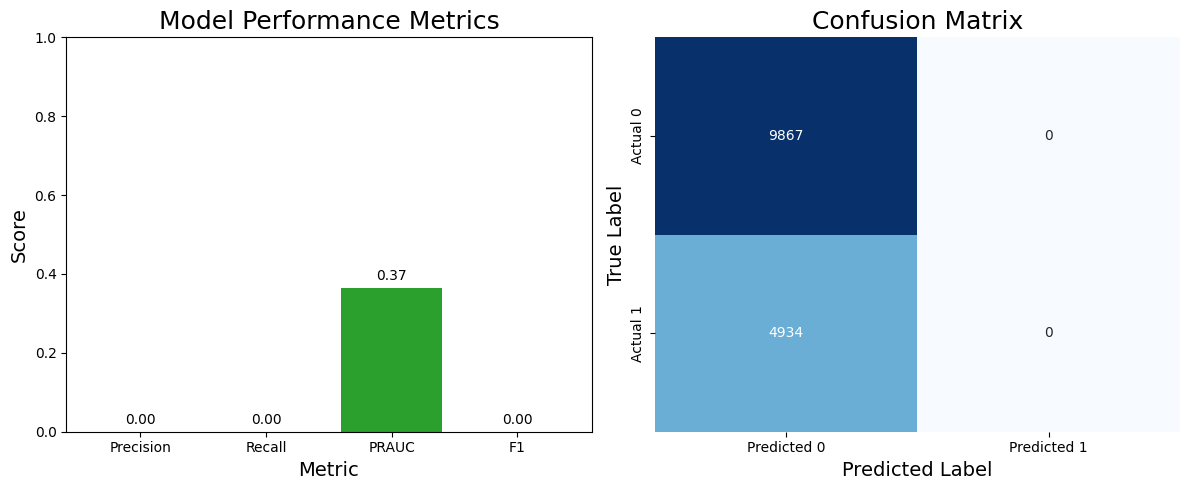

In [16]:
clf = LogisticRegression(C=0.0001, random_state=0)
clf, metrics_clf, conf_matrix_clf = trainEvaluate(
    X_train=X_train, y_train=y_train, 
    X_val=X_val, y_val=y_val, 
    model=clf, plot_results=True
)

### **B.5.4** & **B.5.5**

Now we will train and evaluate Random Forest Classifier with $100$ `estimators` and the default `max_depth`. We will use the same metrics to evaluate the model as the one used for Logistic Regression due to the same reasons explained in **5.3**.

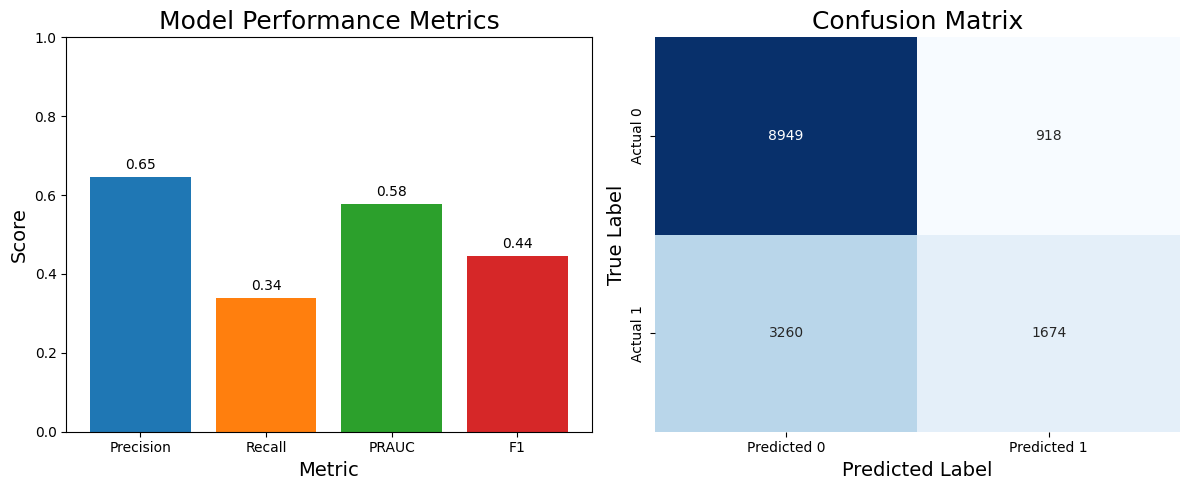

In [17]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc, metrics_rfc, conf_matrix_rfc = trainEvaluate(
    X_train=X_train, y_train=y_train, 
    X_val=X_val, y_val=y_val, 
    model=rfc, plot_results=True
)

We see that Random Forest greatly outperforms Logistic Regression with default parameters. Instead of undersampling we could also perform SMOTE-NC algorithm to oversample the minority class as we did in part 1 of the project or introduce class weights. Still, we will proceed to use the undersampled data with ratio $2:1$.

----------

## **C**. Machine Learning Hyper-parameter optimization (10 pts)

**6.** Use a grid-search to find a better combination C value and "class_weight" value for the previous Logistic Regression Model (you can do a search manually with a loop or use Scikit-learn grid search features) (**2** pts)

**7.1** Use a random search to find a better combination C value and "class_weight" value for the previous Logistic Regression Model.  (you can do a search manually with a loop or use Scikit-learn grid search features) (**2** pts)

**7.2** How many random iterations are needed to find performances as good as your previous grid search? (**2** pts)


**8.1** Plot how the performance metric selected in 5.5 when changing the number of estimators? When changing the depth of the trees (max 10)? (**2** pts)

**8.2** What are the optimal values of these parameters (optimized together)? (**2** pts)

To evaluate the models, we will use F1 Macro Score as discussed before.

### **C.6**

Best Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 3}}


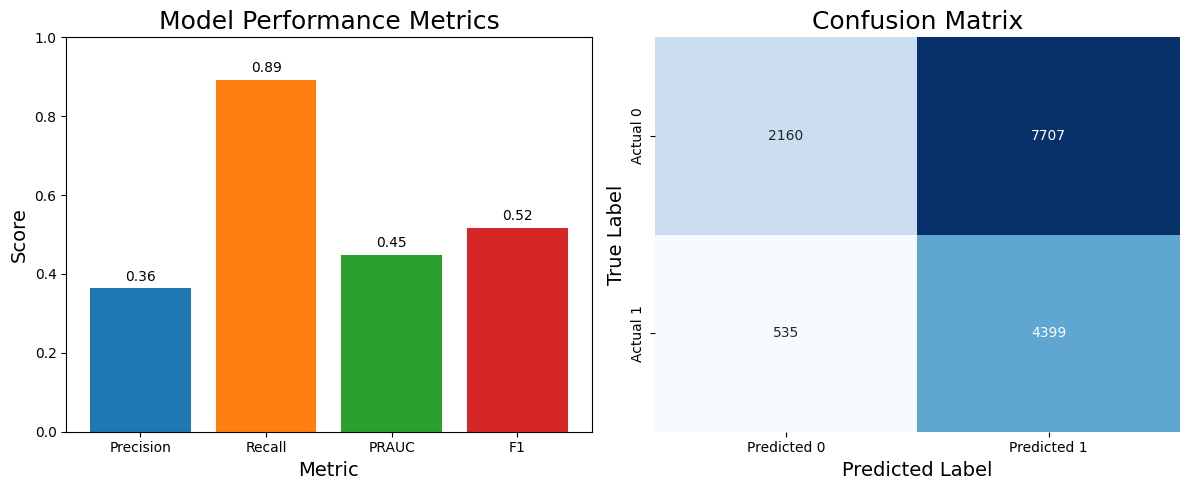

In [18]:
# define the parameter grid
param_grid = {
    "C": [0.0001, 0.01, 0.1, 0.5, 1],
    "class_weight": [None, "balanced", {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}]
}
# create a LogisticRegression model
clf = LogisticRegression(random_state=0)
# initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=clf, 
    param_grid=param_grid, 
    scoring="f1", # f1
    cv=5
)
# fit the model on the training data
grid_search.fit(X_train, y_train)
# extract the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
# use the best model for evaluation
best_clf = grid_search.best_estimator_
best_clf, metrics_clf, conf_matrix_clf = trainEvaluate(
    X_train=X_train, y_train=y_train, 
    X_val=X_val, y_val=y_val, 
    model=best_clf, plot_results=True
)

### **C.7.1**

Best Random Search Parameters: {'C': 0.6028633760716439, 'class_weight': {0: 1, 1: 3}}


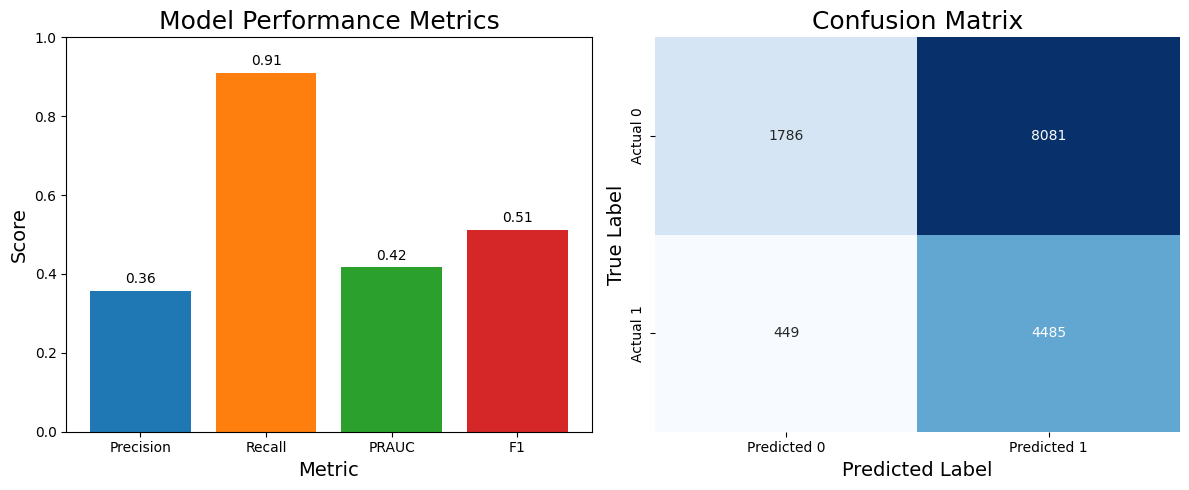

In [19]:
# define the parameter distribution
param_dist = {
    "C": uniform(0.0001, 1),  # uniform distribution for C
    "class_weight": [None, "balanced", {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}]
}
# create a LogisticRegression model
clf = LogisticRegression(random_state=0)
# initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=2,  # number of random iterations
    scoring="f1", # f1
    cv=5,
    random_state=0
)
# fit the model on the training data
random_search.fit(X_train, y_train)
# extract the best parameters
best_random_params = random_search.best_params_
print("Best Random Search Parameters:", best_random_params)
# use the best model for evaluation
best_random_clf = random_search.best_estimator_
best_random_clf, metrics_random_clf, conf_matrix_random_clf = trainEvaluate(
    X_train=X_train, y_train=y_train, 
    X_val=X_val, y_val=y_val, 
    model=best_random_clf, plot_results=True
)

### **C.7.2**

Iteration with n_iter=1: Picked C value is 0.5489135039273247
Iteration with n_iter=3: Picked C value is 0.8473517387841254
Iteration with n_iter=5: Picked C value is 0.8473517387841254
Iteration with n_iter=10: Picked C value is 0.8473517387841254


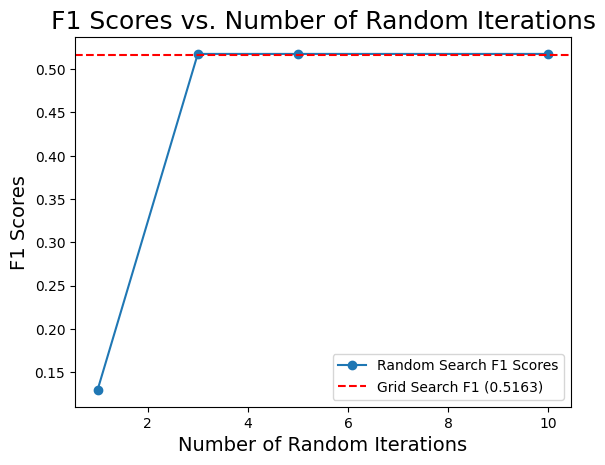

In [20]:
n_iters = [1, 3, 5, 10]
praucs = []
for n_iter in n_iters:
    # create a LogisticRegression model
    clf = LogisticRegression(random_state=0)
    # initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_dist,
        n_iter=n_iter,  # number of random iterations
        scoring="f1", # f1
        cv=5,
        random_state=0
    )
    # fit the model on the training data
    random_search.fit(X_train, y_train)
    # extract the best parameters
    best_random_params = random_search.best_params_
    print(f"Iteration with n_iter={n_iter}: Picked C value is {best_random_params['C']}")
    # use the best model for evaluation
    best_random_clf = random_search.best_estimator_
    best_random_clf, metrics_random_clf, conf_matrix_random_clf = trainEvaluate(
        X_train=X_train, y_train=y_train, 
        X_val=X_val, y_val=y_val, 
        model=best_random_clf, plot_results=False
    )
    praucs.append(metrics_random_clf["F1"])
# plot the F1 scores from random search vs. original grid search F1
plt.plot(n_iters, praucs, label="Random Search F1 Scores", marker="o")
plt.axhline(y=metrics_clf["F1"], color="r", linestyle="--", label=f"Grid Search F1 ({metrics_clf['F1']:.4f})")
plt.title("F1 Scores vs. Number of Random Iterations", fontsize=18)
plt.xlabel("Number of Random Iterations", fontsize=14)
plt.ylabel("F1 Scores", fontsize=14)
plt.legend()
plt.show()

As we can see, it takes around $3$ random iterations to find parameters that allow the Logistic Regression model to perform comparably to the model with parameters found through grid search. The advantage of a random search is the fact that we can pass distributions for the parameters, as we did for parameter $C$.

### **C.8.1**

In [21]:
n_estimators_range = [10, 25, 50, 100, 150, 200]
max_depth_range = [1, 3, 5, 7, 10]
class_weight_range = [None, "balanced", {0: 1, 1: 2}, {0: 1, 1: 3}]

metrics_results = []

for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        for class_weight in class_weight_range:
            rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weight, random_state=0)
            rfc, metrics_rfc, conf_matrix_rfc = trainEvaluate(
                X_train=X_train, y_train=y_train, 
                X_val=X_val, y_val=y_val, 
                model=rfc, plot_results=False
            )
            metrics_results.append({"n_estimators": n_estimators, "max_depth": max_depth, "class_weight": class_weight, "metrics": metrics_rfc})

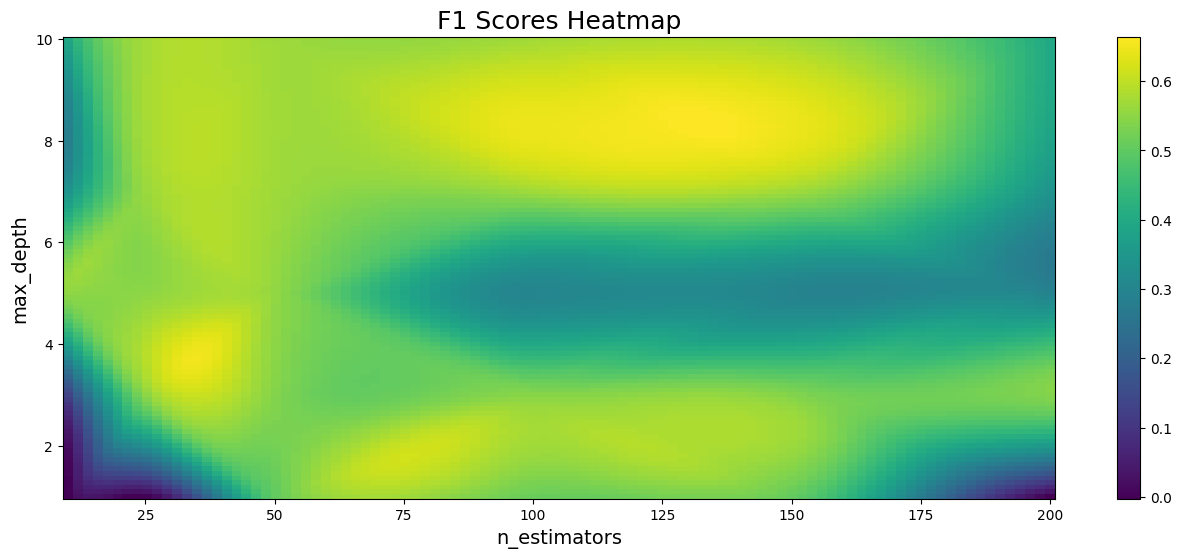

In [22]:
# plot the results
# prepare the data for each metric
n_estimators = []
max_depth = []
f1s = []
# populate the lists with values from metrics_results
for result in metrics_results:
    n_estimators.append(result["n_estimators"])
    max_depth.append(result["max_depth"])
    f1s.append(result["metrics"]["F1"])

# function to create a 2D heatmap
def plot_2d_heatmap(ax, x, y, z):
    # create grid data for heatmap
    grid_x, grid_y = np.meshgrid(
        np.linspace(min(x), max(x), 100),
        np.linspace(min(y), max(y), 100)
    )
    # interpolate z values (weighted_sums) for the grid
    grid_z = griddata((x, y), z, (grid_x, grid_y), method="cubic")
    # plot the heatmap
    c = ax.pcolormesh(grid_x, grid_y, grid_z, cmap="viridis", shading="auto")
    ax.set_title("F1 Scores Heatmap", fontsize=18)
    ax.set_xlabel("n_estimators", fontsize=14)
    ax.set_ylabel("max_depth", fontsize=14)
    fig.colorbar(c, ax=ax)

fig, ax = plt.subplots(figsize=(16, 6))
plot_2d_heatmap(ax, n_estimators, max_depth, f1s)
plt.show()

We notice that the Random Forest model performs the best when `max_depth` is around $8$ and `n_estimators` is around $[125,150]$. But to find the best parameters we can just pick the ones that yield the highest F1 Score.

### **C.8.2**

To find the optimal values for `n_estimators` and `max_depth`, we just pick the model that yields the highest F1 Score.

In [23]:
# initialize variables to store the best values and weighted sum
best_tree = None
best_f1 = -1
# iterate through the metrics results to compute the weighted sum
for result in metrics_results:
    f1 = result["metrics"]["F1"]
    # check if this weighted sum score is better than the best one so far
    if f1 > best_f1:
        best_f1 = f1
        best_tree = {
            "n_estimators": result["n_estimators"],
            "max_depth": result["max_depth"],
            "class_weight": result["class_weight"],
            "F1": best_f1,
            "metrics": result["metrics"]
        }
print(f"Best Tree Parameters: n_estimators: {best_tree['n_estimators']}, max_depth: {best_tree['max_depth']}, class_weight: {best_tree['class_weight']}")
print("F1 Score:", best_tree["F1"])
print("Metrics:", best_tree["metrics"])

Best Tree Parameters: n_estimators: 200, max_depth: 10, class_weight: {0: 1, 1: 3}
F1 Score: 0.5780304148826222
Metrics: {'Precision': 0.4545982350209011, 'Recall': 0.7934738548844751, 'PRAUC': 0.5720724893138309, 'F1': 0.5780304148826222}


Based on the results, we will use $\text{n\_estimators}=200$ and $\text{max\_depth}=10$ with $\text{class\_weight}=\{0: 1, 1: 3\}$

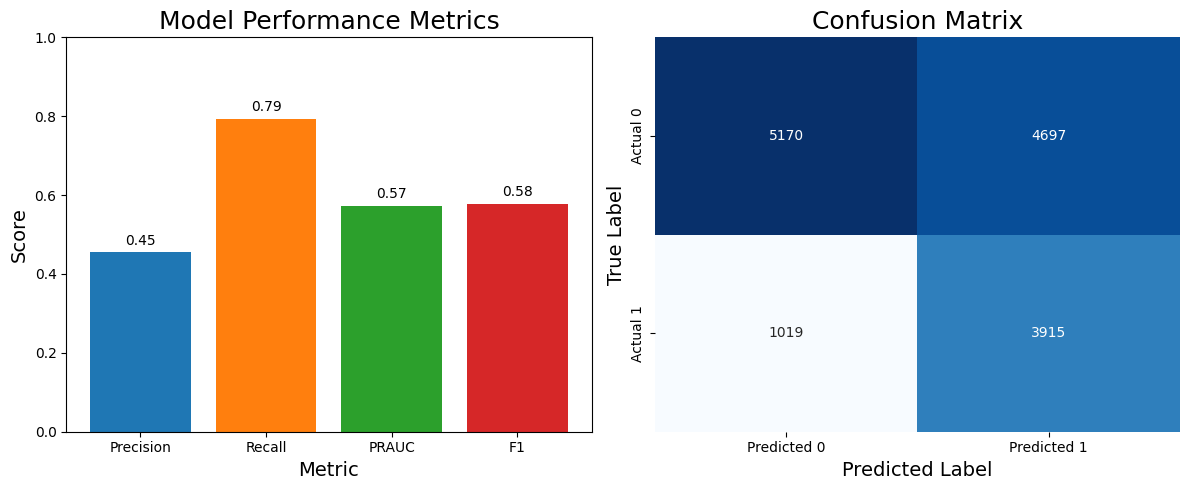

In [24]:
best_n_estimators = 200
best_max_depth = 10
best_class_weight = {0: 1, 1: 3}
# train the best random forest
best_rfc_model = RandomForestClassifier(
    n_estimators=best_n_estimators, max_depth=best_max_depth, class_weight=best_class_weight, 
    random_state=0
)
best_rfc, metrics_best_rfc, conf_matrix_best_rfc = trainEvaluate(
    X_train=X_train, y_train=y_train, 
    X_val=X_val, y_val=y_val, 
    model=best_rfc_model, plot_results=True
)

We see that the model does a pretty good job in classifying the positive class, while losing its perfomance in classifying negative class ($50\%$ of the negative classes are falsly classified as positive).

## **D**. Post Machine Learning Feature inteprepretation (5 pts)

**9.1** Get the features importance of the Optimal Random Forest classifier (obtained in 8) (**2** pts)

**9.2** Are they the features that are the most correlated with the target? (**1** pt)

**10.** Compare the tree structure obtained with visualization (using export_graphviz for instance) of the first tree of your random forest and the last tree of your random forest. How can you explain the differences?  (**2** pts)


### **D.9.1**

In [25]:
# get the feature importances from rfc_smote
importances = best_rfc.feature_importances_
# create a DataFrame to associate the feature importances with their column names
feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
})
# sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)[feature_importance_df["Importance"] > 0.001]
feature_importance_df.head(10)

,Feature,Importance
33,EXT_SOURCE_3,0.168799
84,EXT_SOURCE_2^2,0.100399
69,EXT_SOURCE_2,0.089482
83,AMT_GOODS_PRICE EXT_SOURCE_2,0.045124
74,AMT_INCOME_TOTAL EXT_SOURCE_2,0.041320
81,AMT_ANNUITY EXT_SOURCE_2,0.034889
11,DAYS_BIRTH,0.034582
78,AMT_CREDIT EXT_SOURCE_2,0.033368
12,DAYS_EMPLOYED,0.029118
38,DAYS_LAST_PHONE_CHANGE,0.021048


### **D.9.2**

In [26]:
# calculate the correlations between each feature and the target
correlations = data.corr()
# extract the correlations of the features with the target
correlation_with_target = correlations['TARGET'].drop('TARGET')  # drop the correlation of TARGET with itself
# create a DataFrame to hold the correlations
correlation_df = pd.DataFrame({
    "Feature": correlation_with_target.index,
    "Correlation with TARGET": correlation_with_target.values
})
# sort the correlation DataFrame by the absolute correlation values
correlation_df = correlation_df.sort_values(by="Correlation with TARGET", ascending=False, key=abs)
# compare the most important features with their correlations
comparison_df = feature_importance_df.merge(correlation_df, on="Feature")
# display the sorted DataFrame
comparison_df = comparison_df.sort_values(by="Importance", ascending=False)
comparison_df.head(10)

,Feature,Importance,Correlation with TARGET
0,EXT_SOURCE_3,0.168799,-0.254781
1,EXT_SOURCE_2,0.089482,-0.260794
2,DAYS_BIRTH,0.034582,0.137256
3,DAYS_EMPLOYED,0.029118,0.084044
4,DAYS_LAST_PHONE_CHANGE,0.021048,0.097964
5,DAYS_ID_PUBLISH,0.020866,0.088933
6,AMT_ANNUITY,0.017978,-0.024129
7,AMT_CREDIT,0.016644,-0.055887
8,DAYS_REGISTRATION,0.015686,0.075194
9,AMT_GOODS_PRICE,0.015375,-0.072348


We can see that the features that *Random Forest Classifier* sees as imporant for splitting are not as strongly correlated with the target variable, meaning that feature importance does not always align with correlation with the target variable. **Feature importance** is related to how much it contributes to **reducing the impurity**, **not** how well it is **correlated** with the target variable.

### **D.10**

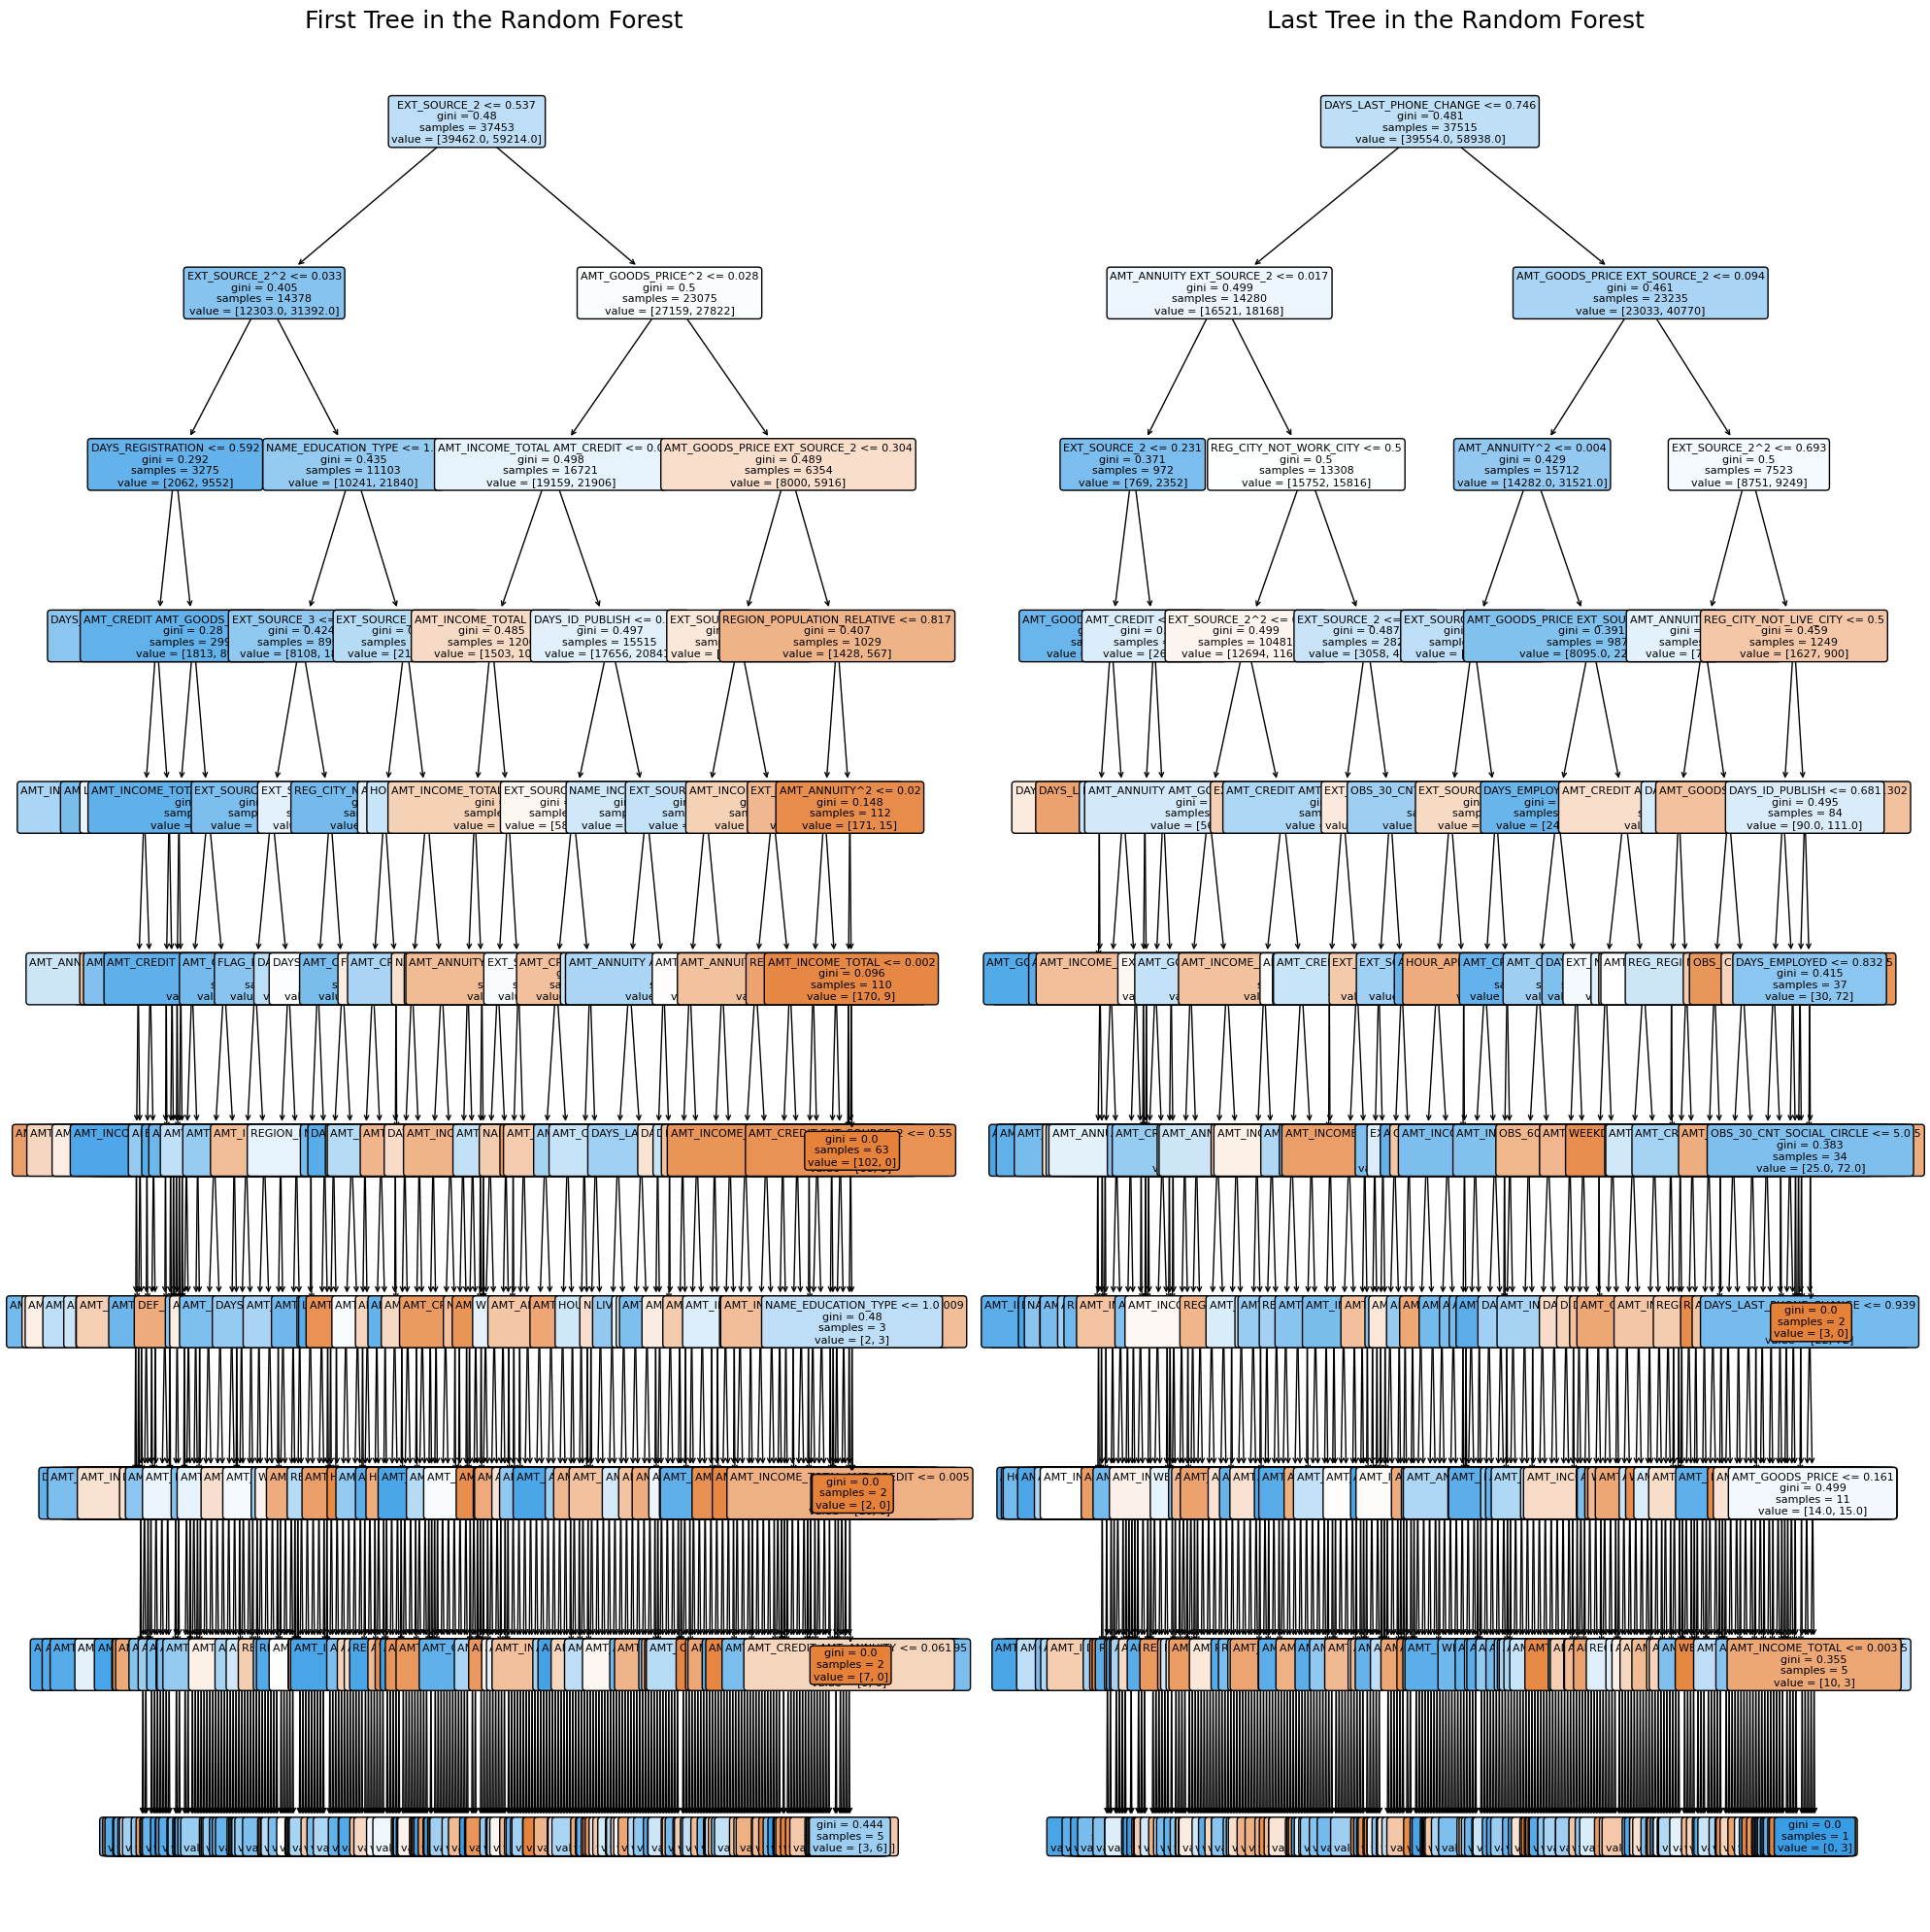

In [27]:
# get the first and last trees from the Random Forest
first_tree = best_rfc.estimators_[0]
last_tree = best_rfc.estimators_[-1]

# plot trees
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
# first tree
plot_tree(first_tree, feature_names=X.columns, filled=True, ax=axes[0], rounded=True, fontsize=8)
axes[0].set_title("First Tree in the Random Forest", fontsize=18)
# last tree
plot_tree(last_tree, feature_names=X.columns, filled=True, ax=axes[1], rounded=True, fontsize=8)
axes[1].set_title("Last Tree in the Random Forest", fontsize=18)

plt.tight_layout()
plt.show()

- Depth: The depth of the both first and last trees are the same.
- Feature Selection: We see different features at the root and at different levels of the trees that are used for splitting. This is natural: each tree in a random forest is trained on a different subset of the data. Random forests **randomly** sample features when splitting nodes, so different trees might prioritize different features based on the samples they see. For example, `AMT_CREDIT` is used as the root node in the first while, while it first appears on the third level in the last tree. But `EXT_SOURCE_3` is on the second level in both of the trees, sugesting that this node is important. However, the value used for splitting in `EXT_SOURCE_3` is slightly different: in the first tree it is $<=0.545$, while in the last tree it is $<=0.536$.
- Split Thresholds: The same can be said about the actual split thresholds for the features. They might differ, as different samples of the data can lead to different optimal splits for each tree (as in `EXT_SOURCE_3` example).

## **E**. Evasion attacks (12pts)

**11.** Implement the Algorithm 2 from the research paper in https://arxiv.org/pdf/1605.07277.pdf

Section 6.5 of the research paper describes the intuition of the algorithm and the different parameters (**5** pts).

PS: the whole paper gives you a good understand of adversarial attacks and is a recommended reading

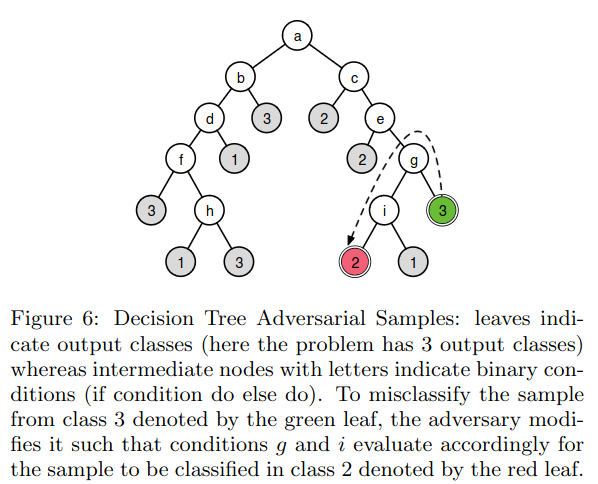

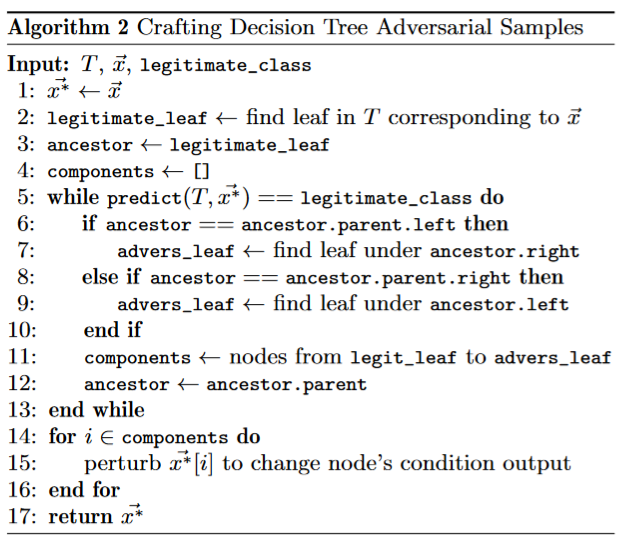

### **E.11**

The algorithm in the paper can be somewhat confusing. As described, the while loop condition remains the same throughout, potentially leading to an infinite loop. The only stopping condition I can see is reaching the root node, but there’s no clear reason why reaching the root is necessary. Also, it seems like the algorithm only works with continious features; it doesn't take into account categorical features.

Based on the Figure 6 in their paper we can modify the algorithm in the following way. We follow the same steps in the while loop, i.e. find an `advers_leaf`, but **make sure that it belongs to a different class than the `legitimate_leaf`**. If no such `advers_leaf` is found, we move to the parent of the `legitimate_leaf` and search there (to the opposite side of the `legitimate_leaf`). Once we have this `advers_leaf`, we identify the path (i.e., `components`) from the `legit_leaf` to the `advers_leaf` and use those nodes to determine which features to perturb in `x_adv`. After making these perturbations, we continue the while loop, i.e. perturb `x_adv` until the misclassification has been achieved.

Since `advers_leaf` and path from the `legit_leaf` to the `advers_leaf` will remain the same for the entire process, we don’t need to recalculate it within the loop. Instead, we can identify `advers_leaf` and the path from `legit_leaf` to `advers_leaf` once before the while loop starts. Then, within the while loop, we simply apply the perturbations to `x_adv` based on components until the desired misclassification is achieved.

For the perturbations, we could base the perturbation magnitude on the variance or standard deviation of the feature, e.g., $0.01\times\text{std\_dev}$ which would give ua a more consistent, data-driven adjustment that’s proportionate to the variability of each feature. This approach ensures that the perturbation is small relative to the natural range or distribution of each feature.

In [28]:
def get_node_relations(tree):
    """
    Build a node relation map in the given tree.
    """
    # initialize a dictionary to store each node's relations
    node_relations = {}
    # get the children arrays
    left_children = tree.tree_.children_left
    right_children = tree.tree_.children_right
    # initialize parent array with -1 (indicating no parent)
    parent = np.full(tree.tree_.node_count, -1)
    # populate parent relationships
    for i in range(tree.tree_.node_count):
        if left_children[i] != -1:  # if there is a left child
            parent[left_children[i]] = i
        if right_children[i] != -1:  # if there is a right child
            parent[right_children[i]] = i
    # populate the node_relations dictionary
    for node in range(tree.tree_.node_count):
        node_relations[node] = {
            'left': left_children[node] if left_children[node] != -1 else None,
            'right': right_children[node] if right_children[node] != -1 else None,
            'parent': parent[node] if parent[node] != -1 else None
        }
    return node_relations

def find_adv_leaf(tree, node_relations, start_node, legitimate_class, path=None):
    """
    Recursively find the first leaf node under start_node with a different class than legitimate_class.
    Store the path from legitimate_leaf to the found adversarial leaf.
    """
    if path is None:
        path = [] # initialize path if not provided
    # check if this node is a leaf node
    if node_relations[start_node]["left"] is None and node_relations[start_node]["right"] is None:
        # check if the leaf node has a different class
        if tree.tree_.value[start_node].argmax() != legitimate_class:
            return start_node, path  # found adversarial leaf and path
        
    path.append(start_node)
    # recursive search on children nodes
    if node_relations[start_node]["left"] is not None:
        # pass shallow copy of path as path[:]
        adv_leaf, left_path = find_adv_leaf(tree, node_relations, node_relations[start_node]["left"], legitimate_class, path[:])
        if adv_leaf is not None:
            return adv_leaf, left_path
    if node_relations[start_node]["right"] is not None:
        # pass shallow copy of path as path[:]
        adv_leaf, right_path = find_adv_leaf(tree, node_relations, node_relations[start_node]["right"], legitimate_class, path[:])
        if adv_leaf is not None:
            return adv_leaf, right_path

    return None, []  # if no adversarial leaf is found

def my_decision_tree_attack(tree, node_relations, x, feature_names, features_stds):
    """
    Slightly modified version of the Algorithm 2 from
    "Transferability in Machine Learning: from Phenomena to Black-Box Attacks using Adversarial Samples"
    """
    print("Trying to perturb data...")
    # 1. initialize the adversarial sample as copy of x
    x_adv = x.copy()
    # 2. find the legitimate_leaf node in the tree corresponding to the original sample
    legitimate_leaf = tree.apply([x])[0]
    # 3. find class and parent of legitimate_leaf
    legitimate_class = tree.predict([x])[0]
    legitimate_leaf_parent = node_relations[legitimate_leaf]["parent"]
    # 4. find an adversarial leaf with a different class and the path (components) from legitimate_leaf to adv_leaf
    if legitimate_leaf == node_relations[legitimate_leaf_parent]["left"]:
        adv_leaf, components = find_adv_leaf(tree, node_relations, node_relations[legitimate_leaf_parent]["right"], legitimate_class)
    else:
        adv_leaf, components = find_adv_leaf(tree, node_relations, node_relations[legitimate_leaf_parent]["left"], legitimate_class)
    components.insert(0, legitimate_leaf_parent)
    components_names = [feature_names[tree.tree_.feature[component]] for component in components]
    print("     Found components to perturb: " + ", ".join(component for component in components_names))
    print(f"     Adversarial leaf node is {len(components)} nodes away for the legitimate node")
    # 6. apply perturbations in the while loop until misclassification occurs
    print("     Perturbing components...")
    while tree.predict([x_adv])[0] == legitimate_class:
        # perturb x_adv based on components to steer towards adv_leaf
        for component in components:
            feature = tree.tree_.feature[component]
            threshold = tree.tree_.threshold[component]
            perturbation = 0.001 * features_stds[feature]
            if x_adv[feature] <= threshold:
                perturb_value = x_adv[feature] + perturbation
                if perturb_value >= 1:
                    print("     Could not perturb the data...")
                    return x_adv, components_names, False
                else:
                    x_adv[feature] = x_adv[feature] + perturbation
                    print(f"Value after pertubation: {x_adv[feature]}")
            else:
                perturb_value = x_adv[feature] - perturbation
                if perturb_value <= 0:
                    print("     Could not perturb the data...")
                    return x_adv, components_names, False
                else:
                    x_adv[feature] = x_adv[feature] - perturbation
                    print(f"Value after pertubation: {x_adv[feature]}")
    print("Perturbation success!")
    return x_adv, components_names, True

In [29]:
features_stds = X_train.std()
features_stds

NAME_CONTRACT_TYPE              0.273376
CODE_GENDER                     0.481628
FLAG_OWN_CAR                    0.470697
FLAG_OWN_REALTY                 0.462003
CNT_CHILDREN                    0.677622
                                  ...   
AMT_ANNUITY AMT_GOODS_PRICE     0.021114
AMT_ANNUITY EXT_SOURCE_2        0.054264
AMT_GOODS_PRICE^2               0.036372
AMT_GOODS_PRICE EXT_SOURCE_2    0.082471
EXT_SOURCE_2^2                  0.240113
Length: 85, dtype: float64

In [30]:
node_relations = get_node_relations(last_tree)
for i, (key, value) in enumerate(node_relations.items()):
    print(f"{key}: {value}")
    if i == 4:
        break

0: {'left': 1, 'right': 526, 'parent': None}
1: {'left': 2, 'right': 153, 'parent': 0}
2: {'left': 3, 'right': 88, 'parent': 1}
3: {'left': 4, 'right': 19, 'parent': 2}
4: {'left': 5, 'right': 6, 'parent': 3}


In [31]:
success = False
while not success:
    x_legit = X_train.sample(n=1).iloc[0]
    x_adv, components_adv, success = my_decision_tree_attack(first_tree, node_relations, x_legit, X_train.columns, features_stds)

Trying to perturb data...
     Found components to perturb: AMT_GOODS_PRICE EXT_SOURCE_2
     Adversarial leaf node is 1 nodes away for the legitimate node
     Perturbing components...
Value after pertubation: 0.04369882394373417
Value after pertubation: 0.043616352468729025
Value after pertubation: 0.04353388099372388
Value after pertubation: 0.04345140951871873
Value after pertubation: 0.043368938043713584
Value after pertubation: 0.04328646656870844
Value after pertubation: 0.04320399509370329
Value after pertubation: 0.04312152361869814
Value after pertubation: 0.043039052143692996
Value after pertubation: 0.04295658066868785
Value after pertubation: 0.0428741091936827
Value after pertubation: 0.042791637718677555
Value after pertubation: 0.04270916624367241
Value after pertubation: 0.04262669476866726
Value after pertubation: 0.042544223293662115
Value after pertubation: 0.04246175181865697
Value after pertubation: 0.04237928034365182
Value after pertubation: 0.042296808868646674

In [32]:
print(f"Data before perturbation at impacted components:\n{x_legit[components_adv]}\n")
print(f"Data after perturbation at impacted components:\n{x_adv[components_adv]}")

Data before perturbation at impacted components:
DAYS_BIRTH    0.089454
Name: 58769, dtype: float64

Data after perturbation at impacted components:
DAYS_BIRTH    0.107556
Name: 58769, dtype: float64


**12.1** Either using the attack you implemented in question 11. or using the library Adversarial Robustness Toolbox (https://github.com/Trusted-AI/adversarial-robustness-toolbox/), generate a Decision Tree Attack on the validation set on the first tree of the random forest (cf question 10). (**5** pts).


**12.2** Evaluate the AUC on the generated adversarial examples. It should be lower than the AUC obtained on question 8.2. (**2** pts).

### **E.12.1**

In [33]:
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import DecisionTreeAttack

# create sklearn classifier based on first_tree
first_tree_classifier = SklearnClassifier(model=first_tree)
# initialize attack
attack = DecisionTreeAttack(classifier=first_tree_classifier)
# generate adversarial examples on the validation set
X_val_adv = attack.generate(x=X_val.to_numpy())

Decision tree attack: 100%|██████████| 14801/14801 [00:10<00:00, 1382.34it/s]


### **E.12.2**

Let us evaluate the best random forest model found in **C.8.2** on the validation set after it has been adversarially attacked.

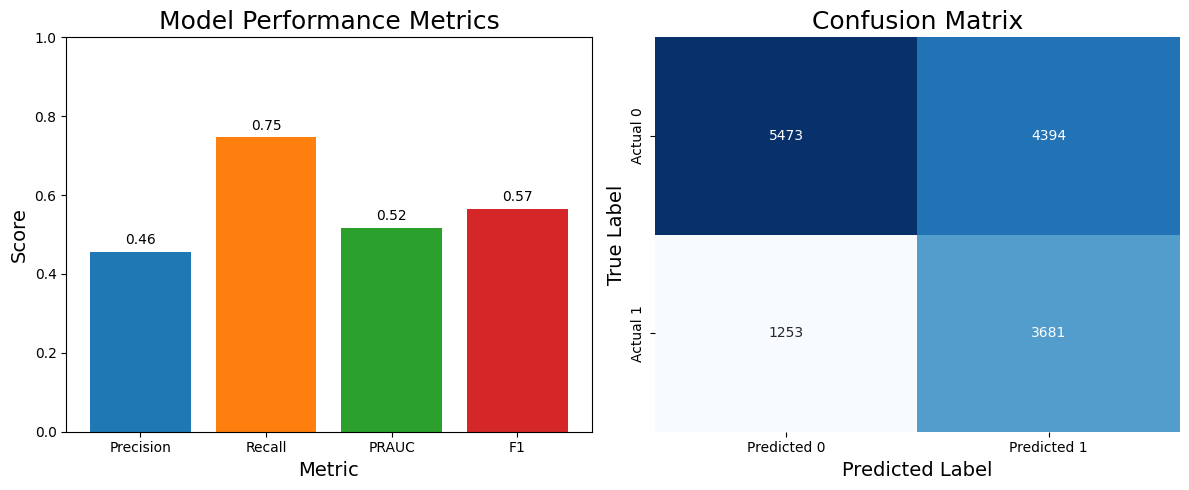

In [34]:
adv_rfc, metrics_adv_rfc, conf_matrix_adv_rfc = trainEvaluate(
    X_train=X_train, y_train=y_train, 
    X_val=X_val_adv, y_val=y_val, 
    model=best_rfc_model, plot_results=True
)

In [35]:
print(f"PRAUC before attack: {metrics_best_rfc['PRAUC']}")
print(f"PRAUC after attack: {metrics_adv_rfc['PRAUC']}")

PRAUC before attack: 0.5720724893138309
PRAUC after attack: 0.5169110648454085


Indeed, the PRAUC Score and drops by $\approx6\%$ after the advesarial attack on the validation set.

## **F**. Semi-supervised Learning (8pts)

It is recommended to optimize the hyper parameters of each of the techniques.

**13.1** Using LabelPropagation from sklearn library, fit the labels using the validation set and infer the labels of the training set (**3** pts)

### **F.13.1**

**NOTE**: using `LabelPropagation` and `LabelSpreading` is memory consuming, since these two methods create a graph for all the data we have. We will thus use a subset of data, say $50\%$ of all the data we have ($50\%$ of training data and $50\%$ of validation data).

In [15]:
# split 50% of the train data while keeping class balance
X_train_50, _, y_train_50, _ = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)
# split 50% of the validation data while keeping class balance
X_val_50, _, y_val_50, _ = train_test_split(
    X_val, y_val, test_size=0.5, stratify=y_val, random_state=42
)

# combine X_train_50 and X_val_50 into a single dataset and mark the labels in y_train_50 as "unknown" (e.g., -1 as in the documentation of LabelPropagation)
X_combined = pd.concat([X_train_50, X_val_50], axis=0)
# convert float64 columns to float32 to save memory
float64_cols = X_combined.select_dtypes(include=['float64']).columns
X_combined[float64_cols] = X_combined[float64_cols].astype(np.float32)
X_combined = X_combined.to_numpy() # convert to NumPy array
y_combined = np.concatenate([y_train_50, y_val_50], axis=0)
# mask the labels of X_train_50 as -1 to infer them
y_combined[:len(y_train_50)] = -1

In [23]:
from sklearn.semi_supervised import LabelPropagation

# apply LabelPropagation
label_propagation = LabelPropagation()
label_propagation.fit(X_combined, y_combined)
# extract inferred labels for X_train
y_train_inferred_lp = label_propagation.transduction_[:len(y_train_50)]

**13.2** Using LabelSpreading from sklearn library, fit the labels using the validation set and infer the labels of the training set (**3** pts)

### **F.13.2**

In [21]:
from sklearn.semi_supervised import LabelSpreading

label_spreading = LabelSpreading()
label_spreading.fit(X_combined, y_combined)
# extract inferred labels for X_train
y_train_inferred_ls = label_spreading.transduction_[:len(y_train_50)]

**14.** Compare the silhouette performance metrics and the accuracy of the labels of the clusters obtained using each technique. (**2** pts)

### **F.14**

We expect `LabelSpreading` to achieve higher accuracy and silhouette scores, since it is a improved version of `LabelPropagation` that introduces regularization term, a normalized Laplacian of the graph to smooth out the label propagation process.

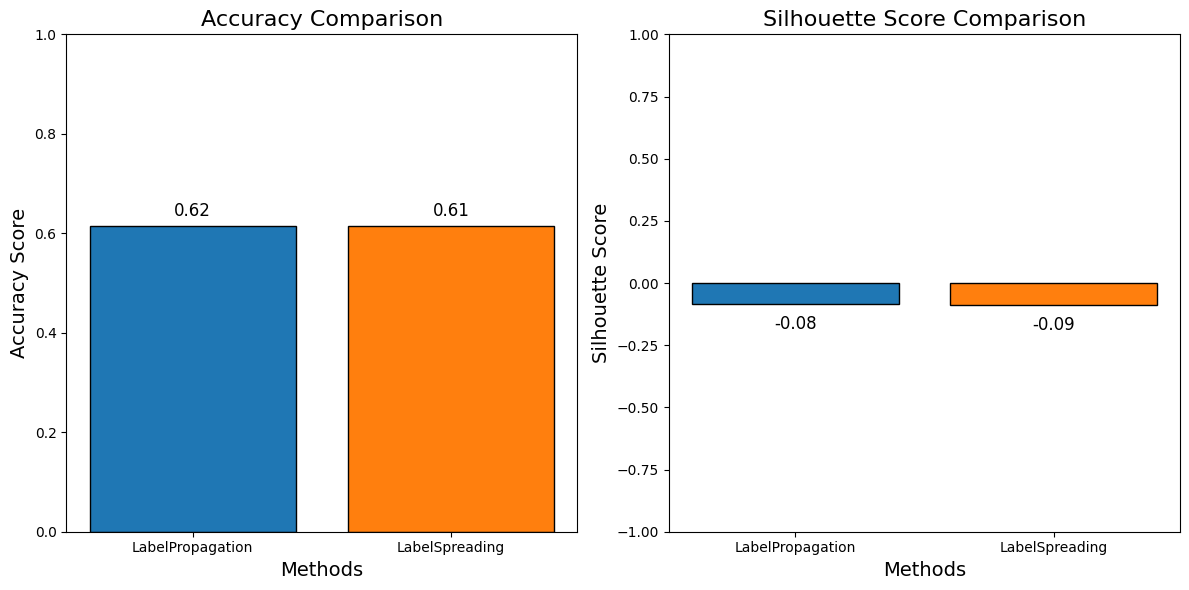

In [31]:
silhouette_lp = silhouette_score(X_train_50, y_train_inferred_lp) # silhouette score for LabelPropagation
accuracy_lp = accuracy_score(y_train_50, y_train_inferred_lp) # accuracy for LabelPropagation
silhouette_ls = silhouette_score(X_train_50, y_train_inferred_ls) # silhouette score for LabelSpreading
accuracy_ls = accuracy_score(y_train_50, y_train_inferred_ls) # accuracy for LabelSpreading
metrics = ["LabelPropagation", "LabelSpreading"]
accuracy_values = [accuracy_lp, accuracy_ls]
silhouette_values = [silhouette_lp, silhouette_ls]
# results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# accuracy
axs[0].bar(metrics, accuracy_values, color=["#1f77b4", "#ff7f0e"], edgecolor="black")
axs[0].set_ylim(0, 1)
axs[0].set_title("Accuracy Comparison", fontsize=16)
axs[0].set_xlabel("Methods", fontsize=14)
axs[0].set_ylabel("Accuracy Score", fontsize=14)
for i, v in enumerate(accuracy_values):
    axs[0].text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=12)
# silhouette score
axs[1].bar(metrics, silhouette_values, color=["#1f77b4", "#ff7f0e"], edgecolor="black")
axs[1].set_ylim(-1, 1)
axs[1].set_title("Silhouette Score Comparison", fontsize=16)
axs[1].set_xlabel("Methods", fontsize=14)
axs[1].set_ylabel("Silhouette Score", fontsize=14)
for i, v in enumerate(silhouette_values):
    axs[1].text(i, v + (0.02 if v >= 0 else -0.1), f"{v:.2f}", ha="center", fontsize=12)
plt.tight_layout()
plt.show()

Even though the accuracy is around $60\%$, it does not imply that the methods might be good for our data. This is supported by the silhouette score, which is negative and indicates that the samples may be in the wrong cluster, as they are closer to a neighboring cluster than to the assigned cluster.